In [5]:
pip install transformers

     |████████████████████████████████| 1.4MB 13.7MB/s 
     |████████████████████████████████| 2.9MB 53.2MB/s 
     |████████████████████████████████| 890kB 52.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=eda1783a66e470e73c8dc9acb57e056c151146b875300ac4903111f3ed142950
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [15]:
%matplotlib inline
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
import numpy as np
from tqdm.notebook import tqdm


from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn


from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [22]:
all_train_data = pd.read_csv('train.csv', delimiter=',')
train_data = pd.DataFrame(all_train_data, columns=["category", "noisyTextDescription", "gender", "baseColour", "season", "usage"])
train_data['concData'] = train_data[['gender', 'baseColour', 'season', 'usage', 'noisyTextDescription']].agg(' '.join, axis=1)
train_data['concData'] = train_data['concData'].str.lower()
possible_labels = train_data.category.unique()
# print(train_data['category'].value_counts())
# print(train_data.concData)
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
train_data['label'] = train_data.category.replace(label_dict)

X_train, X_val, y_train, y_val = train_test_split(train_data.index.values, 
                                                  train_data.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=train_data.label.values)

train_data['data_type'] = ['not_set']*train_data.shape[0]

train_data.loc[X_train, 'data_type'] = 'train'
train_data.loc[X_val, 'data_type'] = 'val'
train_data.groupby(['category', 'label', 'data_type']).count()



noisyTextDescription  ...  concData
category                 label data_type                        ...          
Accessories              26    train                        54  ...        54
                               val                          10  ...        10
Apparel Set              25    train                        51  ...        51
                               val                           9  ...         9
Bags                     4     train                      1289  ...      1289
                               val                         228  ...       228
Belts                    14    train                       325  ...       325
                               val                          57  ...        57
Bottomwear               11    train                      1127  ...      1127
                               val                         199  ...       199
Cufflinks                23    train                        43  ...        43
                               val                           7  ...         7
Dress                    8     train                       203  ...       203
                               val                          36  ...        36
Eyewear                  19    train                       451  ...       451
                               val                          80  ...        80
Flip Flops               1     train                       392  ...       392
                               val                          69  ...        69
Fragrance                22    train                       443  ...       443
                               val                          78  ...        78
Free Gifts               24    train                        52  ...        52
                               val                           9  ...         9
Headwear                 9     train                       109  ...       109
                               val                          19  ...        19
Innerwear                12    train                       773  ...       773
                               val                         137  ...       137
Jewellery                10    train                       447  ...       447
                               val                          79  ...        79
Lips                     18    train                       164  ...       164
                               val                          29  ...        29
Loungewear and Nightwear 17    train                       189  ...       189
                               val                          33  ...        33
Makeup                   20    train                       100  ...       100
                               val                          18  ...        18
Nails                    16    train                       127  ...       127
                               val                          23  ...        23
Sandal                   3     train                       394  ...       394
                               val                          69  ...        69
Saree                    15    train                       182  ...       182
                               val                          32  ...        32
Scarves                  0     train                        50  ...        50
                               val                           9  ...         9
Shoes                    6     train                      3066  ...      3066
                               val                         541  ...       541
Socks                    5     train                       289  ...       289
                               val                          51  ...        51
Ties                     21    train                       111  ...       111
                               val                          19  ...        19
Topwear                  2     train                      6535  ...      6535
                               val                        1154  

In [129]:
print(y_train)
print(y_val)

[ 6  2 20 ... 26  1  2]
[ 2 19  2 ... 10  2 13]


In [69]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    train_data[train_data.data_type=='train'].concData.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


encoded_data_val = tokenizer.batch_encode_plus(
    train_data[train_data.data_type=='val'].concData.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_data[train_data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(train_data[train_data.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
b = train_data[train_data.data_type=='train'].concData
b.values

array(['women grey summer casual femella women ankle-length grey aq-s800wd-1evdfad170',
       'unisex green summer casual converse unisex casual skirts slipper',
       'women red summer ethnic velia women acetone kurta', ...,
       'men brown summer casual adipower & taylor men brown quince',
       'women beige winter casual rocia women r348 flats',
       'men steel winter casual fastrack men black amethyst watch'],
      dtype=object)

In [68]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model: model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [70]:

batch_size = 10

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [71]:

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [72]:


def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [73]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }     

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/finetuned_BERT_epoch_conc_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

KeyboardInterrupt: ignored

In [75]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/finetuned_BERT_epoch_conc_3.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Scarves
Accuracy: 8/9

Class: Flip Flops
Accuracy: 62/69

Class: Topwear
Accuracy: 1094/1154

Class: Sandal
Accuracy: 49/69

Class: Bags
Accuracy: 207/228

Class: Socks
Accuracy: 38/51

Class: Shoes
Accuracy: 511/541

Class: Watches
Accuracy: 172/187

Class: Dress
Accuracy: 24/36

Class: Headwear
Accuracy: 15/19

Class: Jewellery
Accuracy: 74/79

Class: Bottomwear
Accuracy: 161/199

Class: Innerwear
Accuracy: 124/137

Class: Wallets
Accuracy: 54/63

Class: Belts
Accuracy: 43/57

Class: Saree
Accuracy: 30/32

Class: Nails
Accuracy: 23/23

Class: Loungewear and Nightwear
Accuracy: 29/33

Class: Lips
Accuracy: 24/29

Class: Eyewear
Accuracy: 75/80

Class: Makeup
Accuracy: 14/18

Class: Ties
Accuracy: 17/19

Class: Fragrance
Accuracy: 77/78

Class: Cufflinks
Accuracy: 6/7

Class: Free Gifts
Accuracy: 0/9

Class: Apparel Set
Accuracy: 6/9

Class: Accessories
Accuracy: 7/10



In [ ]:
a = predictions[0,:]
aa = torch.nn.Softmax(a)
print(aa)
print(true_vals[0])
# print(train_data['category'].value_counts())

Softmax(
  dim=[-0.84572184  0.07338294  8.774733   -1.2275288  -1.0032171  -0.8572529
   -0.03614509 -1.3208802   1.3326362  -0.29648906 -2.009458    0.33529347
    1.4200376  -0.5324605  -1.0452851  -0.01469556 -0.6112479  -1.0591668
   -0.4005716  -1.3342444  -0.81184083 -0.7361178  -0.18918885 -1.03976
   -1.1046914   0.01366117 -1.641715  ]
)
2


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Make prediction for test data set


In [18]:
all_test_data = pd.read_csv('test.csv', delimiter=',')
test_data = pd.DataFrame(all_test_data, columns=["id","category", "noisyTextDescription", "gender", "baseColour", "season", "usage"])
test_data['concData'] = test_data[['gender', 'baseColour', 'season', 'usage', 'noisyTextDescription']].agg(' '.join, axis=1)
test_data['concData'] = test_data['concData'].str.lower()



In [77]:
b = test_data.concData.values
b

array(['men black summer casual chromozome men black fashion vest',
       'women green summer casual elle women green color clash top',
       'women black winter casual baggit women chotu mayur black palms',
       ..., 'men white fall sports nike men hell with white tshirts',
       'women red spring casual lakme holi to five day apricot nectar lip k9',
       'unisex red summer casual percorso unisex red grit backpack'],
      dtype=object)

In [78]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_test = tokenizer.batch_encode_plus(
    test_data.concData.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)



input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.randint(1,27,(test_data.shape[0],1)  )


dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [79]:
input_ids_test.shape

torch.Size([21628, 256])

In [80]:
t = test_data
y = t.shape
y

(21628, 8)

In [81]:

batch_size = 10

dataloader_test = DataLoader(dataset_test, 
                              shuffle = False, 
                              batch_size=batch_size, )


In [82]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/finetuned_BERT_epoch_conc_3.model', map_location=torch.device('cpu')))

_,predictions_t,_ = evaluate(dataloader_test)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [96]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from numpy import asarray
from numpy import save
p_t = predictions_t
p_t = np.asarray(p_t)
layer = tf.keras.layers.Softmax()
p_s_t = layer(p_t).numpy()
save('test_bert_last_layer_softmax.npy', p_s_t)



# Submission of BERT predictor

In [90]:
pred_labels_t = np.argmax(p_s_t, axis = 1) # We take the highest probability

# changing numerical labels to string vategories
order_categories = []
for i in range(len(pred_labels_t)):
    a = possible_labels[pred_labels_t[i]]
    order_categories.append(a)
    
sub = {'id': test_data.id.tolist() , 'category': order_categories}
sub_df = pd.DataFrame(sub, columns=["id","category"])
sub_df.to_csv('bert_t.csv',index=False)

# Make prediction for train and validation data set

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    train_data.concData.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)



input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_data.label.values)



dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)


NameError: ignored

In [137]:

batch_size = 10

dataloader_train = DataLoader(dataset_train, 
                              shuffle = False, 
                              batch_size=batch_size)


In [136]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/finetuned_BERT_epoch_conc_3.model', map_location=torch.device('cpu')))

_,predictions,true_vals = evaluate(dataloader_train)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Scarves
Accuracy: 42/59

Class: Flip Flops
Accuracy: 428/461

Class: Topwear
Accuracy: 7567/7689

Class: Sandal
Accuracy: 386/463

Class: Bags
Accuracy: 1467/1517

Class: Socks
Accuracy: 276/340

Class: Shoes
Accuracy: 3535/3607

Class: Watches
Accuracy: 1219/1248

Class: Dress
Accuracy: 181/239

Class: Headwear
Accuracy: 101/128

Class: Jewellery
Accuracy: 511/526

Class: Bottomwear
Accuracy: 1196/1326

Class: Innerwear
Accuracy: 874/910

Class: Wallets
Accuracy: 350/418

Class: Belts
Accuracy: 315/382

Class: Saree
Accuracy: 208/214

Class: Nails
Accuracy: 143/150

Class: Loungewear and Nightwear
Accuracy: 196/222

Class: Lips
Accuracy: 174/193

Class: Eyewear
Accuracy: 520/531

Class: Makeup
Accuracy: 108/118

Class: Ties
Accuracy: 113/130

Class: Fragrance
Accuracy: 520/521

Class: Cufflinks
Accuracy: 45/50

Class: Free Gifts
Accuracy: 0/61

Class: Apparel Set
Accuracy: 52/60

Class: Accessories
Accuracy: 41/64



In [149]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from numpy import asarray
from numpy import save
p = predictions
p = np.asarray(p)
layer = tf.keras.layers.Softmax()
p_s = layer(p).numpy()
save('train_bert_last_layer_softmax.npy', p_s)
p_s[3]

array([6.9904572e-04, 1.3045125e-03, 2.7615356e-04, 9.8791891e-01,
       5.9517333e-04, 3.3135866e-04, 1.4257208e-03, 4.9804675e-04,
       2.2898366e-04, 4.4996044e-04, 3.4036112e-04, 1.0236414e-03,
       5.4328772e-05, 2.6454244e-04, 3.3172939e-04, 3.7788288e-04,
       1.9460521e-04, 3.4820172e-04, 1.1851261e-04, 2.4488842e-04,
       9.0491194e-05, 5.8105530e-04, 4.5516784e-04, 1.3371206e-04,
       4.3393479e-04, 2.6696763e-04, 1.0121001e-03], dtype=float32)

# train the ensemble network


In [23]:
from numpy import load
train_bert_transform = np.load('/content/train_bert_last_layer_softmax.npy')
train_cnn_transform = np.load('/content/train_cnn_last_layer_softmax (1).npy')

print(train_bert_transform.argmax(axis = 1))
print(train_cnn_transform.argmax(axis = 1))
print(labels)

[5 1 2 ... 6 7 2]
[2 1 2 ... 6 7 2]


NameError: ignored

In [24]:
train_transform = np.concatenate((train_bert_transform,train_cnn_transform), axis = 1)
labels = np.array(train_data.label.tolist(), dtype = 'int32')


In [25]:
x_train, x_validate, y_train, y_validate = train_test_split(train_transform, labels, test_size=0.15, random_state=42,stratify=labels)
print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)

import keras

y_train = keras.utils.to_categorical(y_train, len(train_data.category.unique()))
y_validate = keras.utils.to_categorical(y_validate, len(train_data.category.unique()))



(18382, 54)
(18382,)
(3245, 54)
(3245,)


In [26]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [30]:
def create_model_en():

    model = Sequential()

    model.add(Dense(1024, input_shape = (54,)))
    model.add(Activation('relu'))
    model.add(Dropout(0))

    model.add(Dense(512))
    model.add(Activation('relu')) 
    model.add(Dropout(0))

    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.35))

    model.add(Dense(128))
    model.add(Activation('relu')) 
    model.add(Dropout(0.35))

    model.add(Dense(64))
    model.add(Activation('relu')) 
    model.add(Dropout(0))

    model.add(Dense(32))
    model.add(Activation('relu')) 
    model.add(Dropout(0))




    
         
    model.add(Dense(27))
    model.add(Activation('softmax'))

    return model

In [31]:
def train(model, epochs, data_augmentation, opt):

    # Compile the model before using it
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # create a callback that will save the best model while training
    save_best_model = ModelCheckpoint('best_model_en_.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

    # train without data augmentation
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_validate, y_validate),
                            shuffle=True,
                            callbacks=[save_best_model],
                            verbose=0)

    # train with data augmentation
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                            epochs=epochs,
                            validation_data=(x_validate, y_validate),
                            callbacks=[save_best_model],
                            verbose=1)
    
    return history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              56320     
_________________________________________________________________
activation_11 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_12 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

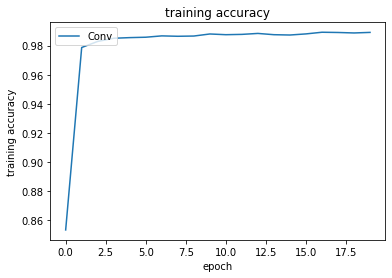

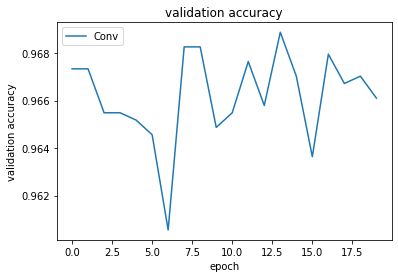

In [32]:
# train and evaluate conv model


batch_size = 120
optimizer = keras.optimizers.Adam()
num_classes = len(train_data.category.unique())
en_model = create_model_en()
history = train(en_model, epochs=20, data_augmentation= False , opt=optimizer,)
#saved_model = load_model('best_model.h5')
#scores = saved_model.evaluate(x_test, y_test, verbose=1)

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()


#print('Test accuracy convolutional network:', scores[1])


# testing ensemble nn


In [100]:
from numpy import load
test_bert_transform = np.load('/content/test_bert_last_layer_softmax.npy')
test_cnn_transform = np.load('/content/test_cnn_last_layer_softmax.npy')

print(test_bert_transform.argmax(axis = 1))
print(test_cnn_transform.argmax(axis = 1))

[12  2  4 ...  2 18  4]
[ 2  2 14 ... 22 18  4]


In [103]:
from keras.models import load_model
model_en = load_model('/content/best_model_en.h5')

In [10]:
test_transform = np.concatenate((test_bert_transform,test_cnn_transform), axis = 1)

In [11]:
predictions_en = model_en.predict(test_transform)

NameError: ignored

In [9]:
pred_labels_en = np.argmax(predictions_en, axis = 1) # We take the highest probability

# changing numerical labels to string vategories
order_categories = []
for i in range(len(pred_labels_en)):
    a = possible_labels[pred_labels_en[i]]
    order_categories.append(a)
    
sub = {'id': test_data.id.tolist() , 'category': order_categories}
sub_df = pd.DataFrame(sub, columns=["id","category"])
sub_df.to_csv('20804524_moghaddas_ensemble.csv',index=False)

NameError: ignored

# Using of the sum of two probabilities (CNN probability and bert txt recognition)


In [20]:
from numpy import load
test_bert_transform = np.load('/content/test_bert_last_layer_softmax.npy')
test_cnn_transform = np.load('/content/test_cnn_last_layer_softmax.npy')

total_p = test_bert_transform + test_cnn_transform
pred_labels_en = np.argmax(total_p, axis = 1) # We take the highest probability

# changing numerical labels to string vategories
order_categories = []
for i in range(len(pred_labels_en)):
    a = possible_labels[pred_labels_en[i]]
    order_categories.append(a)
    
sub = {'id': test_data.id.tolist() , 'category': order_categories}
sub_df = pd.DataFrame(sub, columns=["id","category"])
sub_df.to_csv('20804524_moghaddas_ensemble_sum.csv',index=False)
